In [1]:
import astropy
from scipy.optimize import minimize, curve_fit
from gaia_tools import query
import emcee
import corner
from scipy.interpolate import interp1d
from galpy.util import bovy_plot
from scipy.interpolate import CubicSpline
from galpy.util import bovy_coords, bovy_plot
import pandas

from misc import *
from random import randint

import warnings
warnings.simplefilter("ignore")

import matplotlib.colors as mcolors

%pylab inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


In [2]:
bprpMg_query='''SELECT -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag AS mg, bp_rp FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND parallax > 4'''

query.cache.nickname(bprpMg_query,'cmd_query')

True

In [3]:
out= query.query(bprpMg_query,local=False)
mg= out['mg']; bprp= out['bp_rp']
bprp_edges= arange(0.7,2.1+0.1,0.1)
Mg_edges= zeros((len(bprp_edges)-1,2))

In [4]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
  
def findbin(mag,around):
    y,x= histogram(mag,bins=101)
    x= [(x[i]+x[i+1])/2. for i in range(101)]
    popt,pcov = curve_fit(gaus,x[argmax(y)-around[0]:argmax(y)+around[1]],y[argmax(y)-around[0]:argmax(y)+around[1]],p0=[350000.,x[argmax(y)],1.])

    xmodel= linspace(-3,15,10000)
    mean= popt[1]
    var= abs(popt[2])
    
    return [round(mean-2.*var,2),round(mean+2.*var,2)]
    

for i in range(len(bprp_edges)-1):
    a= [5,7] if (i<13) else [17,17]
    if (i>16):
        a=[31,31]
    
    Mg_edges[i]= findbin(mg[(bprp>bprp_edges[i])*(bprp<bprp_edges[i+1])],around=a)

In [11]:
queries= []
for i in range(len(Mg_edges)):
    queries.append("""SELECT cos(RADIANS(b))*(1/parallax)*cos(RADIANS(l)) AS x, 
cos(RADIANS(b))*(1/parallax)*sin(RADIANS(l)) AS y, 
(1/parallax)*sin(RADIANS(b)) AS z
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag BETWEEN 7 AND 17
AND (1/parallax)*cos(RADIANS(b)) < 0.25 
AND parallax_over_error > 5
AND bp_rp BETWEEN {0:.2f} AND {1:.2f}
AND -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag BETWEEN {2:.1f} AND {3:.1f}
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"""\
          .format(bprp_edges[i],
                  bprp_edges[i+1],
                  Mg_edges[i,0],
                  Mg_edges[i,1]))

for i,q in enumerate(queries):
    nick= 'ncount_quals'+str(round(bprp_edges[i],1))
    query.cache.nickname(q,nick)

In [12]:
out07= query.query(queries[0],local=False)
out08= query.query(queries[1],local=False)
out09= query.query(queries[2],local=False)
out10= query.query(queries[3],local=False)
out11= query.query(queries[4],local=False)
out12= query.query(queries[5],local=False)
out13= query.query(queries[6],local=False)
out14= query.query(queries[7],local=False)
out15= query.query(queries[8],local=False)
out16= query.query(queries[9],local=False)
out17= query.query(queries[10],local=False)
out18= query.query(queries[11],local=False)
out19= query.query(queries[12],local=False)
out20= query.query(queries[13],local=False)
out21= query.query(queries[14],local=False)

Query finished.


## Test Distances to which 1/parallax is accurate

In [2]:
q= '''SELECT parallax_error,parallax_over_error FROM gaiadr2.gaia_source
WHERE (1/parallax)*cos(RADIANS(b)) < 0.25
AND parallax>0
AND phot_g_mean_mag BETWEEN 16.5 AND 17 '''

In [4]:
out= query.query(q,local=False)
query.cache.nickname(q,'mag_check')

True

In [11]:
pe= out['parallax_error']

In [13]:
dist= 1/(median(pe)*5)
print(median(pe))
print('The furthest distance to which we can trust parallax as a measure of distance is: ',dist, 'kpc') 
print('Accounting for radius of the cylinder',sqrt(dist**2-0.25**2),'kpc')

0.09531313867704089
The furthest distance to which we can trust parallax as a measure of distance is:  2.098346594981833 kpc
Accounting for radius of the cylinder 2.083400689419069 kpc


## Plot multiple MCMC runs

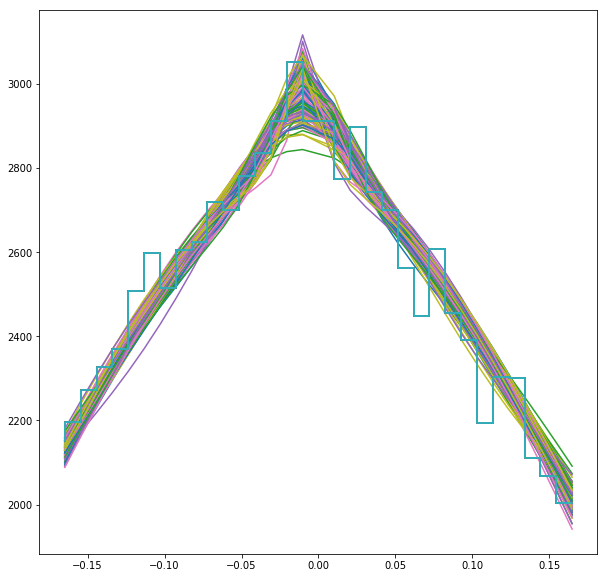

In [23]:
z= br_all[-1].zbin
i= random.randint(0,len(br_all[-1].sample),100)

for j in i:
    p= (br_all[-1].sample[j])
    p[0]= log10(p[0])
    mod= br_all[-1].n_model(p,z)

    plot(z,mod)
    step(z,br_all[-1].N)